### CS/ECE/ISyE 524 &mdash; Introduction to Optimization &mdash; Summer 2018 ###

# Bus Schedule Optimization #

#### Marc Petit (mpetit@wisc.edu), Ge Shi (gshi25@wisc.edu)

### Table of Contents

1. [Introduction](#1.-Introduction)
1. [Mathematical Model](#2.-Mathematical-model)
1. [Solution](#3.-Solution)
1. [Results and Discussion](#4.-Results-and-discussion)
    1. [Trivial Example](#4A)
    2. [Abritrary Long Distances](#4B)
    3. [Abritray Number of Buses](#4C)
    4. [Gerneralization to more Locations](#4D)
    5. [Trade-off: Gas Consuption](#4E)
    6. [Bus Agency Smart Strategies for Operation](#4F)
1. [Conclusion](#5.-Conclusion)

## 1. Introduction ##

This project tries to optimize bus schedules by determining the departure times of the buses at each bus stop. To make this problem more practical, different locations of stops, multiple buses, patterns of passengers' arrivals, and the limitation of gas consumption are accounted for in the whole model. The main objective is maximize the number of passengers transported (Total profit). Moreover, some tradeoff analyses are conducted. In one case, our objective will be to maximize the total passsengers transported and minus total gas consumption, i.e. is the travelled distance. In addition, a trade-off analysis is done for total profit and number of buses. And finally, some plots and tables are displayed and in conclusion the results are discused. All of the models are Mixed Integer Problems since we definitely do not want to chop buses in half.

This problem came about because of continuous interests of sustainable development from the project members, especially the clean energy and public transit. As we all probably know, public transit is increasingly important in the United States because the congestion has spread in many cities of the U.S. Lots of transit agencies try their best to optimizate the buses route and scheduling to improve the quality of services, which leads to a more reliable image of public transit. Furthermore, increases of transit passengers can be obtianed by improved reliability of transit. It is obvious that the public transit can be a more environment-friendly choice than private cars. However, the facts are always ignored that the state-of-the-art technologies such as autonomous vehicles can increase the ownership of cars per household. It can worsen the traffic condition in the city roads and highways. Therefore, making the public transit, especially the buses, more attractive and more effctive can be really cirtical. In addition, using optimization method can be effective and realistic in bus scheduling problems.

To simplify our models to be solvable, we have made some assumptions. However, based on our knowledge, these assumptions are realistic in most situations. We have also realized that some of the assumptions may be unrealistic and need more works in the future models. The limitation of our model will be discussed in [Conclusion](#5.-Conclusion) part.

**Assumptions:**

1. All buses are same type of vehicles with certain capacity.

2. The maximum waiting time for each passenger is 20 minutes.(one time period) Each passenger who comes in one time period don't have patience with waiting for next time period's bus arrival.

3. Since only discrete time points are evaluated, driving times between locations have to be integer multiples of the sampling time.

5. Reference state that the passengers' arrivals follow Poison distribution.(see [this reference](https://link.springer.com/content/pdf/10.1007/s10951-014-0375-z.pdf).) However, in this project a uniform distribution was used to make the results more interesting.

**Data:**

Basically, our data are randomly generated upon our assumptions above. 
For example, passengers numbers are found to follow uniform distribution. The build-in functions in Julia such as rand and uniform are used to create random passengers arriving at each time period.
Furthermore, the distances between location is calculated randomly. As a consequence, the distance, for example, from A ot B can be longer than the distance from B to A. This, however, is not necessarily unrealistic.


**Outline:**

1. Introduction

2. Mathematical model

3. Solution

        (1) Bus dynamics of Two location solution: Includes toy question(2 Places, 1 Step distance, 1 bus solution), various step distances, various numbers of buses, and gerneralization to more locations.

        (2) Trade-offs: Includes effect of gas consumption limitation, and number of buses.

        (3) Purchase Strategies: How to perform a strategy for agency daily operaion within limited cost. 

4.Results and discussion

    It includes different plots and tables to show how the models involves and the results of the optimization in different scenarios. Futhermore, more detailed interpretations are provided to understand the result.

5.Conclusion

    Summary of the entire project. The limiations of our models and future studying directions are discussed.

[flow]: https://cdn-images-1.medium.com/max/1600/1*nJZYTKmyiVyy1amjlF6Dqg.png

## 2. Mathematical model ##

**Summary of the model:** The bus scheduling model has a planning horizon (T). The planning horizon has been divided by t time intervals. The core of the model is based on the fact that each bus won't disappear or be created at each time step. The decision variables, constraints,and objective are as follows:

### Decision Variables
The following dependent decision variables will be used:
* The integer number of buses going from place i to place j at time t. $0 \leq busdrive[i,j,t] \leq num\_buses$
* The real amount the buses are filled, e.g. 3.5 buses are driving from i to j. $0 \leq bus_fil(i,j,t) \leq num\_buses$
* The integer number of passengers trasported from i to j at time t. $trnsprt\_psgnr[i,j,t] \geq 0$ 
* The indicator variable to indicate the number of  buses at a location j $0 <= buslocation[places,time] <= num\_buses$.

### Objective
The objective is to maximize the overall number of people transported, that is all the passengers going from any place i to any place j at any time t.
\begin{equation}
\mathrm{maximize} \sum_{i,j,t} trnsprt\_psgnr(i,j,t)
\end{equation}

### Constraints
The following contraints are used for the optimization model.

**Location Indicator**

The number of buses at location j at time t is the number of buses at location j at time t-1 minus the buses that left from j to i at t-1 plus the buses that came from i to j at t-dist(i,j), where dist(i,j) is the time it takes to go from i to j.
\begin{align}
buslocation(j,t) == &\ buslocation(j,t-1) + \\ \sum_{i,if t > dists(i,j)} & busdrive(i,j,t-dists(i,j)) - \\ \sum_{i} &busdrive(j,i,t-1) \qquad\forall i,j \in places, t \in time
\end{align}

**Bus Dynamics**

A bus can only leave from a place if it located at the bus stop
\begin{align}
\sum_{i in places} busdrive(j,i,t) \leq buslocation(j,t) \qquad \forall j \in places, t \in time
\end{align}

**Demand Contraint**

The number of passengers transported from i to j at time t must equal or less to the number of people waiting to go from i to j at time t.
\begin{align}
trnsprt\_psgnr(i,j,t) \leq demand(i,j,t) 
\qquad \forall i,j \in places, t \in time
\end{align}

**Bus Capacity Contraint**

The number of passengers cannot be more than the bus capacity.
\begin{align}
bus\_fil(i,j,t) &\leq busdrive(i,j,t)\\
bus\_capacity * bus\_fil(i,j,t) &== trnsprt\_psgnr(i,j,t)
\end{align}


## 3. Solution ##


In this section, we code up our models in Julia+ JuMP and solve it. We use packages such as Gurobi to slove MIP models. We have build up some  necessary functions, which has according parameters, outputs and explanations before the code blocks. Because our data are randomly generated upon our assumptions, we have set a seed so that we can get the same data every time. **By changing some or all parameters when calling the functions, different scenarios are modeled with various numbers of buses, bus capacities, stops of buses, ect.**

The used libraries are listed below

In [1]:
using JuMP
using NamedArrays
using Gurobi
using Distributions
using PyPlot

Solve bus is the main optimization function. First, the distance matrix and the demand distribuation is generated, based on the provided data. The the optimization model, as decribed in Section 2 is implemented.

In [2]:
function solvebus(places,num_time_steps,num_buses, max_dist, bus_capacity,average_per_time,lambda )
    seed = 67348529
    srand(seed)
    
    # time vector
    time = 1:num_time_steps
    
    # Create list of all possible routes
    routes = [(i,j) for i in places for j in places] 
                
    # Randomly create the distance matrix, distance are at least one time step and the maximum is defined by max_dist
    # the distance for staying at the same place has to be one, if it was zero the bus could leave and stay at the bus stop
    # without violating the bus dynamics constraintconstraint
    dist_mat = rand(1:max_dist,size(places,1),size(places,1)) 
    for p = 1:length(places)
        dist_mat[p,p] = 1;  
    end
    dists = NamedArray(dist_mat, (places, places), ("from","to"))
    
    # Create Demand Dictionary
    demand = Dict();i = 0;
    #X = Poisson(average_per_time) # Using Poison distribuation
    X = Uniform(0,average_per_time*2) # Using Uniform distribuation
    for r in routes
        i = i + 1;
        demand[r] = trunc.(Int,rand(X, num_time_steps)) * (r[1] != r[2]); #dem_mat[i,:]
    end

    # Use Gurobi Solver, since it is a MIP
    m = Model(solver=GurobiSolver(OutputFlag=0));

    # number of busses going from place to place at time
    # e.g. 3 buses going from A to B
    @variable(m,0 <= busdrive[places,places,time] <= num_buses, Int) 
    # real amount of buses going from place to place at time
    # e.g. 2.4 buses going from A to B
    @variable(m,0 <= bus_fil[places,places,time] <= num_buses) 
    # number of buses at a certain location at a certain time
    # e.g. buslocation[A,3] = 4
    @variable(m,0 <= buslocation[places,time] <= num_buses, Int) # number of buses at place at time
    # number of transported passengers between two places at a time
    # e.g. trnsprt_psgnr[A,B,3] = 78
    @variable(m, trnsprt_psgnr[places,places,time] >= 0, Int) # number of passengers transported from i to j

    for t in time
        for j in places
            if (t == 1) # inital conditions
                # all buses start at A
                @constraint(m,buslocation[j,time[1]] == num_buses * (j == places[1]) )
            else
                # buslocation new = buslocation old + change in buslocation
                @constraint(m,buslocation[j,t] ==
                            sum(busdrive[i,j,t-dists[i,j]] for i in places if t > dists[i,j]) -
                            sum(busdrive[j,i,t-1] for i in places)  + buslocation[j,t-1])

            end
            # bus can only leave from a place if it is there
            @constraint(m,sum(busdrive[j,i,t] for i in places) <= buslocation[j,t] )
            for i in places
                # number of transported passengers must be smaller than the demand
                @constraint(m,trnsprt_psgnr[i,j,t] <= demand[i,j][t])
                # number of bus filling must be smaller than the count of buses
                # e.g. 2.4 buses are going from A to B which requires three buses
                @constraint(m, bus_fil[i,j,t] <= busdrive[i,j,t])
                # the transported passengers are calcuated by multiplying the bus filling a the bus capacity
                # e.g. 2.4 buses * 50 passengers/bus = 120 passengers
                @constraint(m,bus_capacity*bus_fil[i,j,t] == trnsprt_psgnr[i,j,t] )
            end
        end
    end
    # Objective transported passengers - lambda * distance travelled
    @objective(m,Max,sum(trnsprt_psgnr[i,j,t] for t in time,  i in places, j in places) - 
                lambda[1] *sum(busdrive[i,j,t]*dists[i,j] for t in time,  i in places, j in places)   )     

    solve(m)
    goals = zeros(2,1);
    goals[1] = sum(getvalue(trnsprt_psgnr[i,j,t]) for t in time,  i in places, j in places); # transported passengers
    goals[2] = sum(getvalue(busdrive[i,j,t])*dists[i,j] for t in time,  i in places, j in places) # distance travelled
    
    return (busdrive, buslocation, trnsprt_psgnr,dists,time,demand,goals)
end
                            


solvebus (generic function with 1 method)

The optimization does not need to distinguish between buses. It only balances the sum of incoming and outcoming buses at each location. In order to create a schedule, the process_results function, compiles the information in such a way that a route for each bus can be indentified.

In [3]:
function process_results(places,num_time_steps,num_buses, max_dist, bus_capacity,average_per_time,busdrive, buslocation, trnsprt_psgnr,dists,time,demand)
    bus = []
    bd = getvalue(busdrive)
    tp = getvalue(trnsprt_psgnr)
    
    # As a first step for each time steps the travelled routes (arcs) are extracted
    # As a result, a dictionary with arcs is optimed
    # Example:
    # time 1: (A -> B), (A -> C), (A -> D)
    # time 2: (A -> B), (B -> A)
    # time 3: (A -> C), (B -> C), (B -> D)
    # ...
    arc_t = Dict();
    for t in time
        arc= [];
        for i in places
            for j in places
                for k = 1:bd[i,j,t]
                    push!(arc, (i,j))
                end
            end
        end
        arc_t[t] = arc;
    end

    #As a second step an arbritray arc from the arc list at time 1 is removed.
    #Then one arc from the arc list at time 2 is removed that starts at a point that the previous ended
    #This process will be repeated for all time steps until a complete route for one bus is found.
    #These arcs are collected in the bus_list, which is the list of arcs for one bus. 
    #The collected arcs will be removed from the orginal arc_t dictionary. The process will be repeated for each bus until
    #the arc list is empty and all the bus routes are found.
    bus_routes = Dict();
    passgnr_list = Dict();
    for bus_el = 1:num_buses
        bus_list = []; pas_list = []; t = 1;
        while(t <= num_time_steps )
            if(t == 1) # First step
                if(isempty(arc_t[1])) # bus did not move
                    push!(pas_list,0.0 )
                    push!(bus_list, (places[1],places[1]))
                else
                    push!(bus_list,arc_t[1][1]);
                    push!(pas_list,tp[arc_t[t][1][1],arc_t[t][1][2],t] )
                    deleteat!(arc_t[t], findin(arc_t[1], [arc_t[1][1]])[1])
                end
            else
                last_connection = bus_list[end];
                new_route = [];
                for con in arc_t[t]
                    if(con[1] == last_connection[2]) # bus has to start where it stopped at the last trip
                        new_route = con;
                        push!(pas_list,tp[arc_t[t][1][1],arc_t[t][1][2],t] )
                        deleteat!(arc_t[t], findin(arc_t[t], [con])[1]);
                        push!(bus_list,new_route);
                        break;
                    end
                end
                if(isempty(new_route)) # bus did not move
                    push!(pas_list,0.0 )
                    push!(bus_list,(last_connection[2],last_connection[2]))
                end
            end
            t = t +  dists[bus_list[end][1],bus_list[end][2]]; # continue when bus arrives at the next bus stop
            for k = 2:dists[bus_list[end][1],bus_list[end][2]]
                push!(pas_list,0.0 ) # transported passengers is zero while bus is travelling
                push!(bus_list,(bus_list[end][1],bus_list[end][2]));
            end
        end
        bus_routes[bus_el] = bus_list;
        passgnr_list[bus_el] = pas_list;
    end
    return (bus_routes,passgnr_list)
end



process_results (generic function with 1 method)

This functions outputs and displays the solution of each bus schedule and movement.

In [4]:
function output_solution(dists,time,places,demand,num_buses,bus_routes,passgnr_list )
    
    ## Print out distances matrix
    println("DISTANCES   ")
    println(dists)
    println()
    
    ## Print out demand matrix
    println("DEMAND   ")
    print("route", "  |   \t")
    for t in time
        print(t,"\t")
    end
    print("\n-------------------------------------\n")
    for i in places
        for j in places
            print(i, " to ", j, " |    \t")
            for t in time
                print(demand[i,j][t], "\t")
            end
            print("\n")
        end
    end
    
    ## Print out tranported passengers
    print("\n")
    println("Solution   ")
    println("Bus => Route[#passengers] @ every time step")
    for bus_el = 1:num_buses
        print(bus_el, " => ")
        for t in time
            print(bus_routes[bus_el][t], "[", passgnr_list[bus_el][t],  "]\t")
        end
        print("\n\n")
    end 
end
                            
                            

output_solution (generic function with 1 method)

## 4. Results and discussion ##

In this section, it begins with a trival example which has 3 time intervals, 2 bus stops, and only one bus with 50 capacity. Sloving this toy problem can attain the basic understaning of the entire models. As we develops our model in following subsections, more complicate and interesting versions of the problem are demonstrated in detail. Tables are shown for the random distances between each other. In last two versions, plots are created to show the optimal buses trajectories and demand at various locations. Finally, gas consumption tradeoff and purchase strategies are introduced to expand our discussion on this problem.

### 4.A. Trivial Example<a class="anchor" id="4A"></a>

In order to demonstrate the optimization a simple example is used in this paragraph. The simplest example possible consists of two locations between which only one bus, which can hold 50 passengers, will travel back and forth.  To further simplify the problem it is assumed that the distance between the places is one time step. Moreover, to generate some more interesting cases a uniform distribution between 0 and 100 is used to generate the demand at each location.

Below is distances table that shows the distance between pairs of locations.(Unit:Time Intreval)

|  Distance  |  A  |  B  |  
|-------:|-----:|-----:|
|  **A**  |   0  |   1  | 
| **B**  |  1   |   0  |


Demands are shown in the table below.(Unit: Passengers)

| Time Interval\Bus Stops | A to B | B to A  
| -------- |:---------------:| --------------------:| 
| 1        | 40       | 20      | 
| 2        | 53      | 46      | 
| 3        | 3       | 45      | 



In [5]:
places = [:A, :B]
num_time_steps = 3;
num_buses = 1;
max_dist = 1;
bus_capacity = 50;
average_per_time= 30;
lambda = [0];
(busdrive, buslocation, trnsprt_psgnr,dists,time,demand,goals) = solvebus(places,num_time_steps,num_buses, max_dist, bus_capacity,average_per_time,lambda)
(bus_routes,passgnr_list) = process_results(places,num_time_steps,num_buses, max_dist, bus_capacity,average_per_time,busdrive, buslocation, trnsprt_psgnr,dists,time,demand)
output_solution(dists,time,places,demand,num_buses,bus_routes,passgnr_list )
println("Total # of passengers will be ", goals[1])

Academic license - for non-commercial use only
DISTANCES   
2×2 Named Array{Int64,2}
from ╲ to │ :A  :B
──────────┼───────
:A        │  1   1
:B        │  1   1

DEMAND   
route  |   	1	2	3	
-------------------------------------
A to A |    	0	0	0	
A to B |    	40	53	3	
B to A |    	20	46	45	
B to B |    	0	0	0	

Solution   
Bus => Route[#passengers] @ every time step
1 => (:A, :A)[0.0]	(:A, :B)[50.0]	(:B, :A)[45.0]	

Total # of passengers will be 95.0


As it can be seen, that since the bus starts at loc A, it waits one time step to pick up the larger demand at time step two and to avoid the low demand from A to B at time step three. This approach is optimal although the bus cannot pick up all the passengers at time step two because of the limited capacity.

### 4.B Abritrary Long Distances <a class="anchor" id="4B"></a>
In this section the trivial example from 4.A is extend using randomly generated distances. To make the solution more interesting the number of time steps is extended to 10 and the maximum distances are limited to 3.

Below is distances table that shows the distance between pairs of locations.(Unit:Time Intreval)

|  Distance  |  A  |  B  |  
|-------:|-----:|-----:|
|  **A**  |   0  |   4  | 
| **B**  |  3   |   0  |


Demands are shown in the table below.(Unit: Passengers)

| Time Interval\Bus Stops | A to B | B to A  
| -------- |:---------------:| --------------------:| 
| 1        | 17        | 6      | 
| 2        | 9       | 10      | 
| 3        | 8        | 1      | 
| 4        | 10        | 5      | 
| 5        | 20       | 2      | 
| 6        | 22        | 21      | 
| 7        | 0        | 14      | 
| 8        | 11        | 7      | 
| 9        | 21       | 11      | 
| 10        | 11        | 16      | 

In [6]:
places = [:A, :B]
num_time_steps = 10;
num_buses = 1;
max_dist = 4;
bus_capacity = 50;
average_per_time= 12.5;
lambda = [0];
(busdrive, buslocation, trnsprt_psgnr,dists,time,demand,goals) = solvebus(places,num_time_steps,num_buses, max_dist, bus_capacity,average_per_time,lambda)
(bus_routes,passgnr_list) = process_results(places,num_time_steps,num_buses, max_dist, bus_capacity,average_per_time,busdrive, buslocation, trnsprt_psgnr,dists,time,demand)
output_solution(dists,time,places,demand,num_buses,bus_routes,passgnr_list )
println("Total # of passengers will be ", goals[1])

Academic license - for non-commercial use only
DISTANCES   
2×2 Named Array{Int64,2}
from ╲ to │ :A  :B
──────────┼───────
:A        │  1   4
:B        │  3   1

DEMAND   
route  |   	1	2	3	4	5	6	7	8	9	10	
-------------------------------------
A to A |    	0	0	0	0	0	0	0	0	0	0	
A to B |    	17	9	8	10	20	22	0	11	21	11	
B to A |    	6	10	1	5	2	21	14	7	11	16	
B to B |    	0	0	0	0	0	0	0	0	0	0	

Solution   
Bus => Route[#passengers] @ every time step
1 => (:A, :B)[17.0]	(:A, :B)[0.0]	(:A, :B)[0.0]	(:A, :B)[0.0]	(:B, :B)[0.0]	(:B, :A)[21.0]	(:B, :A)[0.0]	(:B, :A)[0.0]	(:A, :B)[21.0]	(:A, :B)[0.0]	

Total # of passengers will be 59.0


For simplicity the distances are generated randomly, which can result in situations where it takes more time to go from A to B than it takes to go from B to A. This discrepancy, however, is not unrealistic due to different traffic patterns and paths in both directions.
For the choosen case here, the bus goes initially from A to B which takes four steps, then stays one time step at B and returns at time step six to A, taking two steps only to return at time step 9 to B. Although, the arrival of the bus is not within the considered time frame, the passengers transported at time step 9 to B are still counted, since it can be assumed the bus driver is reliable and brings all the passengers safely to B.

### 4.C Abritray Number of Buses<a class="anchor" id="4C"></a>
In this section, the optimization will be extended even further to include an arbitray number of buses. To keep the complexity of the results bounded the last example 4.B is extended to three buses.

Because we have set certain seed so that it shows the same distance between pairs of locations.(Unit:Time Intreval)


|  Distance  |  A  |  B  |  
|-------:|-----:|-----:|
|  **A**  |   0  |   4  | 
| **B**  |  3   |   0  |


Same demands are shown in the table below.(Unit: Passengers)

| Time Interval\Bus Stops | A to B | B to A  
| -------- |:---------------:| --------------------:| 
| 1        | 17        | 6      | 
| 2        | 9       | 10      | 
| 3        | 8        | 1      | 
| 4        | 10        | 5      | 
| 5        | 20       | 2      | 
| 6        | 22        | 21      | 
| 7        | 0        | 14      | 
| 8        | 11        | 7      | 
| 9        | 21       | 11      | 
| 10        | 11        | 16      | 

In [7]:
places = [:A, :B]
num_time_steps = 10;
num_buses = 3;
max_dist = 4;
bus_capacity = 50;
average_per_time= 12.5;
lambda = [0];
(busdrive, buslocation, trnsprt_psgnr,dists,time,demand,goals) = solvebus(places,num_time_steps,num_buses, max_dist, bus_capacity,average_per_time,lambda)
(bus_routes,passgnr_list) = process_results(places,num_time_steps,num_buses, max_dist, bus_capacity,average_per_time,busdrive, buslocation, trnsprt_psgnr,dists,time,demand)
output_solution(dists,time,places,demand,num_buses,bus_routes,passgnr_list )
println("Total # of passengers will be ", goals[1])
println(bus_routes[3])

Academic license - for non-commercial use only
DISTANCES   
2×2 Named Array{Int64,2}
from ╲ to │ :A  :B
──────────┼───────
:A        │  1   4
:B        │  3   1

DEMAND   
route  |   	1	2	3	4	5	6	7	8	9	10	
-------------------------------------
A to A |    	0	0	0	0	0	0	0	0	0	0	
A to B |    	17	9	8	10	20	22	0	11	21	11	
B to A |    	6	10	1	5	2	21	14	7	11	16	
B to B |    	0	0	0	0	0	0	0	0	0	0	

Solution   
Bus => Route[#passengers] @ every time step
1 => (:A, :B)[17.0]	(:A, :B)[0.0]	(:A, :B)[0.0]	(:A, :B)[0.0]	(:B, :B)[0.0]	(:B, :A)[22.0]	(:B, :A)[0.0]	(:B, :A)[0.0]	(:A, :B)[21.0]	(:A, :B)[0.0]	

2 => (:A, :A)[0.0]	(:A, :B)[9.0]	(:A, :B)[0.0]	(:A, :B)[0.0]	(:A, :B)[0.0]	(:B, :B)[0.0]	(:B, :A)[14.0]	(:B, :A)[0.0]	(:B, :A)[0.0]	(:A, :B)[11.0]	

3 => (:A, :A)[0.0]	(:A, :A)[0.0]	(:A, :A)[0.0]	(:A, :A)[0.0]	(:A, :A)[0.0]	(:A, :B)[22.0]	(:A, :B)[0.0]	(:A, :B)[0.0]	(:A, :B)[0.0]	(:B, :A)[16.0]	

Total # of passengers will be 131.0
Any[(:A, :A), (:A, :A), (:A, :A), (:A, :A), (:A, :A), (:A, :B), (:A

As we can see from the result above, this is where the models become comlicated. Using pyplot, three subplots are draw. First subplot shows the optimal bus trajectories. The second and third subplots respectively show the demand in A and B stop. From the first plot, we can see that the third bus are not fully utilized. It waits at A stop until the fifth time step.
The plots bellow visualize these dynamics. It can be seen, that buses tend to drive from A to B when the demand is high and then wait until there is a large enough demand to go back from B to A.

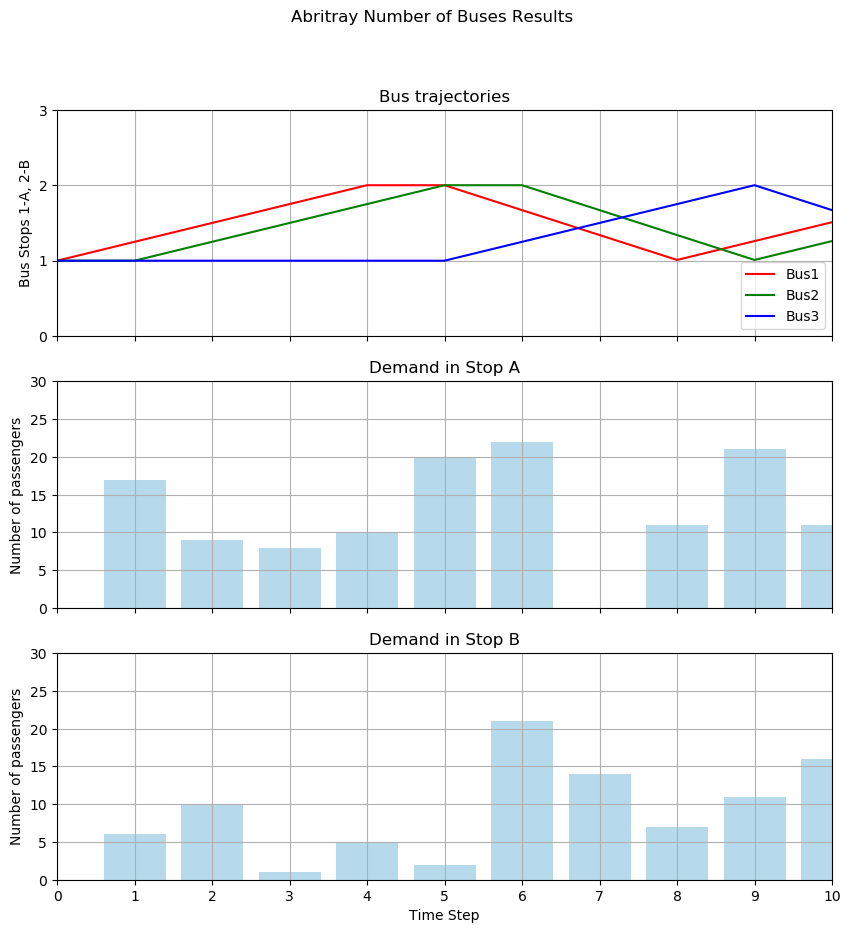

PyObject Text(0.5,0.98,'Abritray Number of Buses Results')

In [8]:
# Reference: (https://gist.github.com/gizmaa/7214002)

# Generate the Bus trajectories


axx1=[0,1,2,3,4,5,6,7,8,9,10,11,12]
ayy1=[1.0]
for i in bus_routes[1]
    if i==(:A, :A)
        push!(ayy1, 1)
    elseif i==(:B, :B)
        push!(ayy1, 2)
    elseif i==(:A, :B)
        push!(ayy1, ayy1[end]+0.25)
    elseif i==(:B, :A)
        push!(ayy1, ayy1[end]-0.33)   
    end
end

axx2=[0,1,2,3,4,5,6,7,8,9,10,11,12,13]
ayy2=[1.0]
for i in bus_routes[2]
    if i==(:A, :A)
        push!(ayy2, 1)
    elseif i==(:B, :B)
        push!(ayy2, 2)
    elseif i==(:A, :B)
        push!(ayy2, ayy2[end]+0.25)
    elseif i==(:B, :A)
        push!(ayy2, ayy2[end]-0.33)   
    end
end

axx3=[0,1,2,3,4,5,6,7,8,9,10,11,12]
ayy3=[1.0]
for i in bus_routes[3]
    if i==(:A, :A)
        push!(ayy3, 1)
    elseif i==(:B, :B)
        push!(ayy3, 2)
    elseif i==(:A, :B)
        push!(ayy3, ayy3[end]+0.25)
    elseif i==(:B, :A)
        push!(ayy3, ayy3[end]-0.33)   
    end
end

# Generate the demand data
xa = [1,2,3,4,5,6,7,8,9,10]
ya = demand[(:A, :B)];
xb = [1,2,3,4,5,6,7,8,9,10]
yb = demand[(:B, :A)];

using PyPlot

###################
##  Shared Axis  ##
###################
fig = figure("pyplot_subplot_touching",figsize=(10,10))
subplots_adjust(hspace=0.2) # Set the vertical spacing between axes
subplot(311) # Create the 1st axis of a 3x1 array of axes
ax1 = gca()
#ax1[:set_xscale] # Set the x axis to a logarithmic scale
setp(ax1[:get_xticklabels](),visible=false) # Disable x tick labels
grid("on")
title("Bus trajectories")
ax1[:plot](axx1,ayy1,color="red")
ax1[:plot](axx2,ayy2,color="green")
ax1[:plot](axx3,ayy3,color="blue")
ax1[:legend](["Bus1", "Bus2","Bus3","Bus4", "Bus5","Bus6"], loc="lower right");
ylabel("Bus Stops 1-A, 2-B")
yticks(0:1.0:3.0) # Set the y-tick range and step size, 0.1 to 0.9 in increments of 0.2
ylim(0.0,3.0) # Set the y-limits from 0.0 to 1.0

subplot(312,sharex=ax1) # Create the 2nd axis of a 3x1 array of axes
ax2 = gca()
b = bar(xa,ya,color="#0f87bf",align="center",alpha=0.3)
setp(ax2[:get_xticklabels](),visible=false) # Disable x tick labels
grid("on")
title("Demand in Stop A")
ylabel("Number of passengers")
yticks(0:5.0:30.0)
ylim(0.0,30.0)

subplot(313,sharex=ax2) # Create the 3rd axis of a 3x1 array of axes
ax3 = gca()
b = bar(xb,yb,color="#0f87bf",align="center",alpha=0.3)
grid("on")
title("Demand in Stop B")
xlabel("Time Step")
xticks(0:1:10)
xlim(0,10)
ylabel("Number of passengers")
yticks(0:5.0:30.0)
ylim(0.0,30.0)
fig[:canvas][:draw]() # Update the figure
suptitle("Abritray Number of Buses Results")

###  4.D. Gerneralization to more Locations<a class="anchor" id="4D"></a>

In this section, the optimization will be extended even further to include more locations. 

Below is distances table that shows the distance between pairs of locations.(Unit:Time Intreval)

|        |  A  |  B  |  C  |  D  |  E  |  F  | 
|-------:|-----:|-----:|-----:|-----:|-----:|-----:|
|**A**  |   0  |   2  |  4  |  1  |  3  |  1  | 
|**B**  |  3   |   0  |  3  |  1  |  2  |  3  |
|**C**  |  4  |  3  |  0   |  1  |  1  |  2  |  
|**D**  |  2  |  4  |  1  |  0   |  3  |  2  |  
|**E**  |  3  |  1  |  1  |  1  |  0   |  2  | 
|**F**  |  1  |  3  |  4  |  4  |  2  |  0   | 


In [9]:
#places = [:Mos_Espa, :Coruscant, :Pau_City, :Mos_Eisley, :Death_Star, :Ewok_Village]
places = [:A, :B, :C, :D, :E, :F]
num_time_steps = 10;
num_buses = 3;
max_dist = 4;
bus_capacity = 50;
average_per_time= 12.5;
lambda = [0];
(busdrive, buslocation, trnsprt_psgnr,dists,time,demand,goals) = solvebus(places,num_time_steps,num_buses, max_dist, bus_capacity,average_per_time,lambda)
(bus_routes,passgnr_list) = process_results(places,num_time_steps,num_buses, max_dist, bus_capacity,average_per_time,busdrive, buslocation, trnsprt_psgnr,dists,time,demand)
output_solution(dists,time,places,demand,num_buses,bus_routes,passgnr_list )
println("Total # of passengers will be ", goals[1])
println(bus_routes[1])
println(bus_routes[2])
println(bus_routes[3])
println(dists)
println(dists[1,2])

Academic license - for non-commercial use only
DISTANCES   
6×6 Named Array{Int64,2}
from ╲ to │ :A  :B  :C  :D  :E  :F
──────────┼───────────────────────
:A        │  1   2   4   1   3   1
:B        │  3   1   3   1   2   3
:C        │  4   3   1   1   1   2
:D        │  2   4   1   1   3   2
:E        │  3   1   1   1   1   2
:F        │  1   3   4   4   2   1

DEMAND   
route  |   	1	2	3	4	5	6	7	8	9	10	
-------------------------------------
A to A |    	0	0	0	0	0	0	0	0	0	0	
A to B |    	12	19	0	22	9	7	17	11	4	3	
A to C |    	17	12	19	15	4	0	7	8	8	6	
A to D |    	10	10	2	2	11	3	16	1	22	17	
A to E |    	8	22	14	21	9	15	7	18	18	1	
A to F |    	0	14	13	14	8	15	24	7	13	10	
B to A |    	23	24	6	6	3	7	5	5	16	7	
B to B |    	0	0	0	0	0	0	0	0	0	0	
B to C |    	12	21	5	10	22	15	17	13	3	0	
B to D |    	22	13	10	1	18	17	10	8	0	11	
B to E |    	9	8	22	12	15	2	21	10	18	21	
B to F |    	2	9	13	24	19	20	6	11	7	22	
C to A |    	0	23	10	24	11	4	15	5	5	18	
C to B |    	6	6	1	18	11	24	17	1	24	13	
C to C

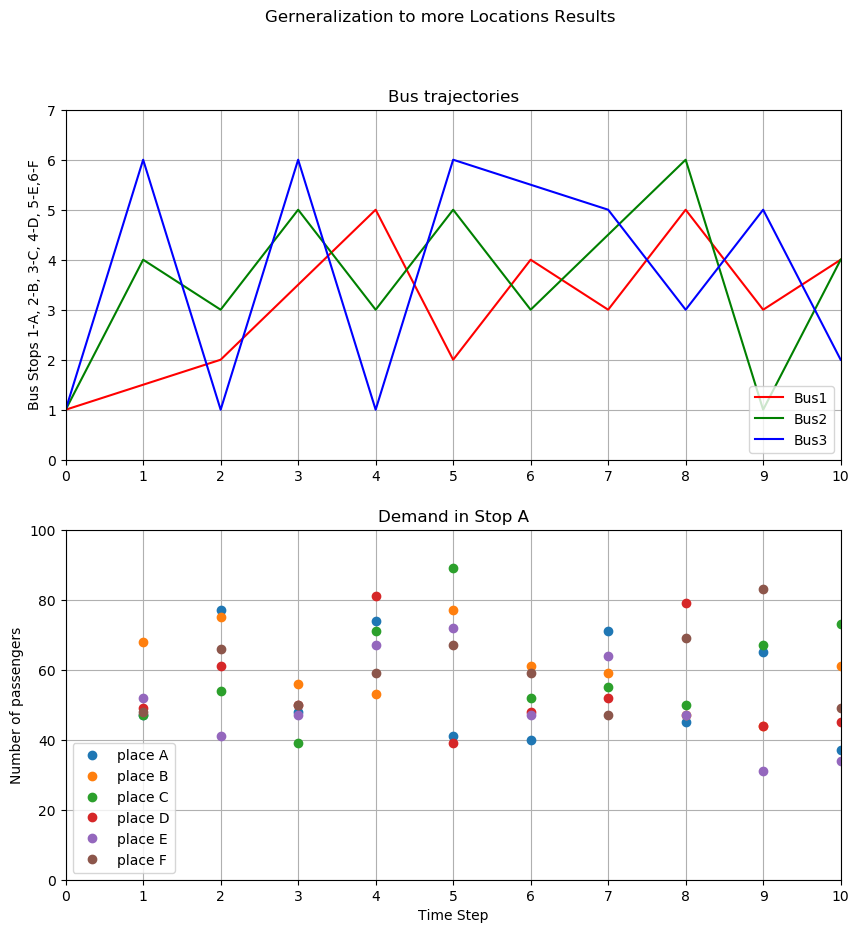

PyObject Text(0.5,0.98,'Gerneralization to more Locations Results')

In [10]:
# Reference: (https://gist.github.com/gizmaa/7214002)

# Generate the Bus trajectories

seq=[:A, :B, :C, :D, :E, :F]

axx1=[0,1,2,3,4,5,6,7,8,9,10]
ayy1=[1.0]
for i in bus_routes[1]
    if i==(:A, :A)
        push!(ayy1, 1)
    elseif i==(:B, :B)
        push!(ayy1, 2)
    else
        push!(ayy1,ayy1[end]+((findfirst(seq, i[2])-findfirst(seq, i[1]))/dists[findfirst(seq, i[1]),findfirst(seq, i[2])] ))
    end
end

axx2=[0,1,2,3,4,5,6,7,8,9,10]
ayy2=[1.0]
for i in bus_routes[2]
    if i==(:A, :A)
        push!(ayy2, 1)
    elseif i==(:B, :B)
        push!(ayy2, 2)
    else
        push!(ayy2,ayy2[end]+((findfirst(seq, i[2])-findfirst(seq, i[1]))/dists[findfirst(seq, i[1]),findfirst(seq, i[2])]))
    end
end

axx3=[0,1,2,3,4,5,6,7,8,9,10]
ayy3=[1.0]
for i in bus_routes[3]
    if i==(:A, :A)
        push!(ayy3, 1)
    elseif i==(:B, :B)
        push!(ayy3, 2)
    else
        push!(ayy3,ayy3[end]+((findfirst(seq, i[2])-findfirst(seq, i[1]))/dists[findfirst(seq, i[1]),findfirst(seq, i[2])] ))
    end
end




using PyPlot

###################
##  Shared Axis  ##
###################
fig = figure("pyplot_subplot_touching",figsize=(10,10))
subplots_adjust(hspace=0.2) # Set the vertical spacing between axes
subplot(211) # Create the 1st axis of a 3x1 array of axes
ax1 = gca()
#ax1[:set_xscale] # Set the x axis to a logarithmic scale
setp(ax1[:get_xticklabels](),visible=true) # Disable x tick labels
grid("on")
title("Bus trajectories")
ax1[:plot](axx1,ayy1,color="red")
ax1[:plot](axx2,ayy2,color="green")
ax1[:plot](axx3,ayy3,color="blue")
ax1[:legend](["Bus1", "Bus2","Bus3","Bus4", "Bus5","Bus6"], loc="lower right");
ylabel("Bus Stops 1-A, 2-B, 3-C, 4-D, 5-E,6-F")
yticks(0:1.0:7.0) # Set the y-tick range and step size, 0.1 to 0.9 in increments of 0.2
ylim(0.0,7.0) # Set the y-limits from 0.0 to 1.0

subplot(212,sharex=ax1) # Create the 2nd axis of a 3x1 array of axes
ax2 = gca()
# Generate the demand data
x = 1:10
for p1 in places
y = sum(demand[p1,p2] for p2 in places);
b = plot(x,y,"o",label=string("place ", p1))
end
legend()
setp(ax2[:get_xticklabels](),visible=true) # Disable x tick labels
grid("on")
title("Demand in Stop A")
ylabel("Number of passengers")
yticks(0:20.0:100.0)
ylim(0.0,100.0)


xlabel("Time Step")
xticks(0:1:10)
xlim(0,10)
ylabel("Number of passengers")
yticks(0:20.0:100.0)
ylim(0.0,100.0)
fig[:canvas][:draw]() # Update the figure
suptitle("Gerneralization to more Locations Results")

### 4.E. Trade-off: Gas Consumption<a class="anchor" id="4E"></a>
In the section the number of passengers and the consumpted gas, i.e. is the total distance travelled is minimized.



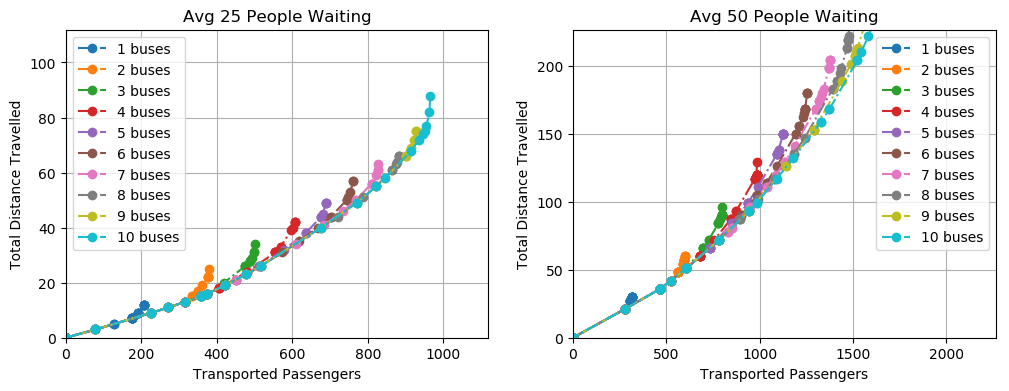

Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic lice

In [11]:
places = [:A, :B, :C]
num_time_steps = 10;
num_buses = 3;
max_dist = 4;
bus_capacity = 50;

lambda = [1];


figure(figsize=(12,4))
subplot(121)
title("Avg 25 People Waiting")
average_per_time= 25;
for num_buses = 1:10
    num_pas = []; num_dis = [];
for lambda = 0:1:50
    (busdrive, buslocation, trnsprt_psgnr,dists,time,demand,goals) = solvebus(places,num_time_steps,num_buses, max_dist, bus_capacity,average_per_time,lambda);
    push!(num_pas,goals[1])
    push!(num_dis,goals[2])
end
    plot(num_pas,num_dis,  "o-.", markersize=6, label=string(num_buses," buses"))
end
legend()
grid("on")
xlabel("Transported Passengers")
ylabel("Total Distance Travelled")
max_pass_possible = sum(demand[i,j][t] for i in places, j in places, t in time[2]:time[end]) + sum(demand[places[1],j][1] for j in places);
xlim(0,max_pass_possible);
ylim(0,max_pass_possible/10);

subplot(122)
average_per_time= 50;
title("Avg 50 People Waiting")
for num_buses = 1:10
    num_pas = []; num_dis = [];
for lambda = 0:1:50
    (busdrive, buslocation, trnsprt_psgnr,dists,time,demand,goals) = solvebus(places,num_time_steps,num_buses, max_dist, bus_capacity,average_per_time,lambda);
    push!(num_pas,goals[1])
    push!(num_dis,goals[2])
end
    plot(num_pas,num_dis*3,  "o-.", markersize=6, label=string(num_buses," buses"))
end
legend()
grid("on")
xlabel("Transported Passengers")
ylabel("Total Distance Travelled")
max_pass_possible = sum(demand[i,j][t] for i in places, j in places, t in time[2]:time[end]) + sum(demand[places[1],j][1] for j in places);

#axis("equal")
xlim(0,max_pass_possible);
ylim(0,max_pass_possible/10);




It is important to note, that although 50 trade-off points per bus plot are evaluated, much fewer points are shown in the plot. The reason is that since, it is an integer problem not any arbritray solution value is feasible. The doted lines are therefore only shown for better visualization but do not represent feasible points.

Moreover, it can be obseved that there is one main curve in the plot, and then each bus curve break off at some point. It should be noted, that the break off lines not good trade off points. The optimal point is in the right bottom corner, that is the maximum amount of passengers possible and zero travelled distance. Since this point is not feasible, good trade-off points are as close as possible to the left corner. To choose a good trade-off point, however, the scaling is important. For these plots a scaling of 10:1 was chosen, i.e. 10 passengers are worth one distance point of travel. Depending on the cost for an additional bus, the break off point can be good indicator when to increase the number of buses.   

### 4.F. Bus Agency Smart Strategies for Operation<a class="anchor" id="4F"></a>
In the section, we assume that in market there are two types of buses that agency can purchase. Based on this assumption, bus agency try to perform a strategy for their daily operaion within limited cost. So before the decision, agency conduct a demand analysis and two possiblities are found.(average 25 passengers and average 50 passengers) As shown in the plots below, if the number of average passengers is 25, then the left plot is refered. If the buses with capacity of 55 passengers are chosen, we can observe that before 11 buses the curve is relatively steep while after 11 buses the curve is flat. It means that the agency should choose 11 buses with capacity of 55 passengers for larger profit. If agency chooses buses with capacity of 30 passengers, it may purchase 13 buses. The similar analysis can be conducted if the average number of passengers is 50, as shown in the right plot.


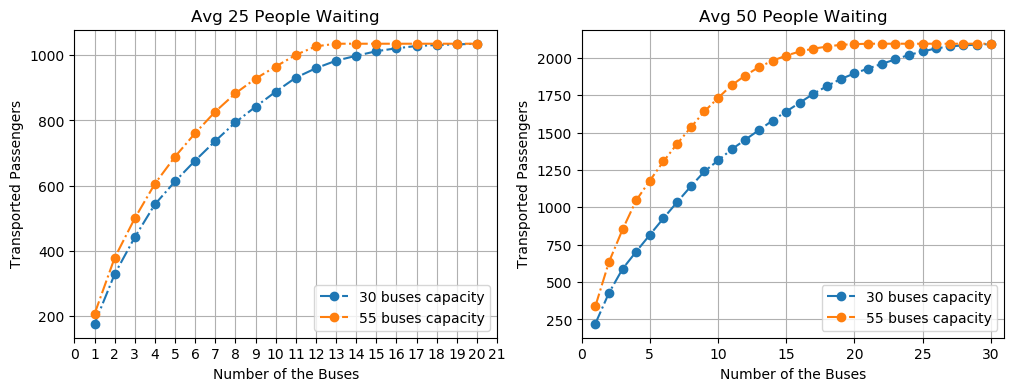

Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic lice

PyObject Text(531.148,0.5,'Transported Passengers')

In [12]:
places = [:A, :B, :C]
num_time_steps = 10;
max_dist = 4;


lambda = [0];


figure(figsize=(12,4))
subplot(121)
title("Avg 25 People Waiting")
average_per_time= 25;
for bus_capacity=[30,55]
num_pas = []
for num_buses = 1:20
    (busdrive, buslocation, trnsprt_psgnr,dists,time,demand,goals) = solvebus(places,num_time_steps,num_buses, max_dist, bus_capacity,average_per_time,lambda);
    push!(num_pas,goals[1])
end
    plot(collect(1:20),num_pas,  "o-.", markersize=6, label=string(bus_capacity," buses capacity"))
end

xticks(0:1:21)
xlim(0,21)

legend()
grid("on")
xlabel("Number of the Buses")
ylabel("Transported Passengers")

subplot(122)
title("Avg 50 People Waiting")
average_per_time= 50;
for bus_capacity=[30,55]
num_pas = []
for num_buses = 1:30
    (busdrive, buslocation, trnsprt_psgnr,dists,time,demand,goals) = solvebus(places,num_time_steps,num_buses, max_dist, bus_capacity,average_per_time,lambda);
    push!(num_pas,goals[1])
end
    plot(collect(1:30),num_pas,  "o-.", markersize=6, label=string(bus_capacity," buses capacity"))
end


xticks(0:5:31)
xlim(0,31)

legend()
grid("on")
xlabel("Number of the Buses")
ylabel("Transported Passengers")


## 5. Conclusion ##

In this report, it is shown how to optimize a bus scheduling problem using Mixed Integer Optimization. The main goal here is to maximize the number of transported people, but some other aspect such as the trade-off between transported people and gas consuption, as well as an evaluation of the right bus capacity and the right number of buses is done.
The model is designed very flexible so that many parameters can be adjusted.
The problem is a nice example of a mixed integer problem since on the one hand the number of buses and passengers has to be integer, on the other hand the bus filling factor is a reel number.
Although the model is very flexible and needs only very few assumptions, there is still some room for improvement. For exmaple a future model should include probablistic models to take into account the likelihood of people taking the bus and also should be able to account for different traffic patterns at different time. Finally, this optimization should be evaluated with real data using real maps. This would also mean, that the buses need to take into account different traffic patterns at different times as well as different speed limits to go between locations.


** References**

Yin, Jiateng, et al. "Dynamic passenger demand oriented metro train scheduling with energy-efficiency and waiting time minimization: Mixed-integer linear programming approaches." Transportation Research Part B: Methodological 97 (2017): 182-213.

Van den Heuvel, A., J. Van den Akker, and M. Van Kooten. "Integrating timetabling and vehicle scheduling in public bus transportation." Reporte Técnico UU-CS-2008-003, Department of Information and Computing Sciences, Utrecht University, Holanda (2008).

Fügenschuh, Armin, and Alexander Martin. "A multicriteria approach for optimizing bus schedules and school starting times." Annals of Operations Research 147.1 (2006): 199-216.

Petering, Matthew EH, Mojtaba Heydar, and Dietrich R. Bergmann. "Mixed-integer programming for railway capacity analysis and cyclic, combined train timetabling and platforming." Transportation Science 50.3 (2015): 892-909.

An Intro to Integer Programming for Engineers: Simplified Bus Scheduling
[website](https://blog.remix.com/an-intro-to-integer-programming-for-engineers-simplified-bus-scheduling-bd3d64895e92)